<a href="https://colab.research.google.com/github/AmandaJMendes/Face-Recognition-With-Metric-Learning/blob/main/face_recog_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem description

1. Train a neural network for facial recognition;
2. Create a database containing the feature vectors predicted by the model for each image in the dataset;
3. Insert an image (target image) of a new person to the database;
4. Recognize the person of item 3 on a new image (query image)

# Instructions


* Before running the code, please ensure that the *dataset_path* and *pretrained_weights_path* variables are set correctly for your environment.
* Run all the cells below sequentially.


#Load files and import libraries

The training dataset was obtained from https://www.kaggle.com/datasets/atulanandjha/lfwpeople

In [ ]:
dataset_path            = "./drive/MyDrive/lfw.zip"
pretrained_weights_path = "./drive/MyDrive/archive.zip"

In [ ]:
!unzip $dataset_path

In [ ]:
!unzip $pretrained_weights_path

Archive:  ./drive/MyDrive/archive.zip
replace vgg_face_weights.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import keras.backend as k
from tensorflow.keras.layers    import ZeroPadding2D, Convolution2D, MaxPooling2D, \
                                       Dropout, Flatten, Activation, Dense, Input, \
                                       BatchNormalization, Lambda
from tensorflow.keras.models    import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define global variables

In [ ]:
IMGS_PATH   = "./lfw/"
IMG_SIZE    = (224, 224, 3)
VALID_SPLIT = 0.2
BATCH_SIZE  = 16
EPOCHS      = 40

# Create database

Create the database as a pandas DataFrame. In this database, each image is represented by its reference (filepath), not by the image (pixels) itself.

Load all filenames and labels from the provided dataset

In [ ]:
labels    = []
filepaths = []

celebs = os.listdir(IMGS_PATH)
for celeb in celebs:
  celeb_files = os.listdir(IMGS_PATH+celeb)
  labels    +=  len(celeb_files) * [celeb] # Label is the folder name
  filepaths += [f"{IMGS_PATH}{celeb}/{file}" for file in celeb_files]

Create database containing *Filepath* and *Label*

In [ ]:
database = pd.DataFrame({"Label": labels, "Filepath": filepaths})

In [ ]:
database.head(5)

,Label,Filepath
0,Lynn_Redgrave,./post-processed/Lynn_Redgrave/Lynn_Redgrave_0...
1,Lynn_Redgrave,./post-processed/Lynn_Redgrave/Lynn_Redgrave_0...
2,Lynn_Redgrave,./post-processed/Lynn_Redgrave/Lynn_Redgrave_0...
3,Lynn_Redgrave,./post-processed/Lynn_Redgrave/Lynn_Redgrave_0...
4,Lynn_Redgrave,./post-processed/Lynn_Redgrave/Lynn_Redgrave_0...


# Create train and validation datasets

Create image pairs. For every *image* in the dataset, two pairs are created:
* Positive pair $($*image*, image from the same class as *image*$)$
* Negative pair $($*image*, image from the same class as *image*$)$

In [ ]:
def generate_image_pairs(database):
  """
  Arguments:
    database: Pandas dataframe containing the columns "Filepath" and "Label"

  Returns:
    Image pairs: array of shape Nx2 (N pairs of filepaths)
    Labels of the pairs: array of shape N
  """

  images = database["Filepath"].values # Get all filepaths
  labels = database["Label"].values    # Get all corresponding labels

  pair_images = []
  pair_labels = []

  for index, image in enumerate(images):
    # Positive images: images from the same class as *image* excluding *image*
    pos_images = images[(labels == labels[index]) & (images != image)]

    # Choose randomly from positive images or use the image itself in the pair
    if len(pos_images):
      pair_images.append((image, np.random.choice(pos_images)))
    else:
      pair_images.append((image, image))

    pair_labels.append(0) # The label of positive pairs is 0

    # Negative images: images from a different class
    # Choose randomly from negative images
    neg_image = np.random.choice(images[labels != labels[index]])
    pair_images.append((image, neg_image))
    pair_labels.append(1) # The label of negative pairs is 0

  return np.array(pair_images), np.array(pair_labels)

In [ ]:
img_pairs, label_pairs = generate_image_pairs(database)

Create tensorflow train and validation datasets from generated image pairs

In [ ]:
def load_and_preprocess_image(img_path):
  """
  Arguments:
    img_path: string containing the path to an image file
  Returns:
    img: Array of shape IMG_SIZE rescaled from 0 to 1
  """
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMG_SIZE[:2])
  img = img / 255.0 # Rescale from (0, 255) to (0, 1)
  return img

In [ ]:
fnamesA_set  = tf.data.Dataset.from_tensor_slices(img_pairs[:, 0]) # Dataset of the first filepath in the pair
fnamesB_set  = tf.data.Dataset.from_tensor_slices(img_pairs[:, 1]) # Dataset of the second filepath in the pair
labels_set   = tf.data.Dataset.from_tensor_slices(label_pairs)     # Dataset of the label (0 if positive pair and 1 if negative pair)

imgsA = fnamesA_set.map(load_and_preprocess_image) # Dataset of the first image in the pair
imgsB = fnamesB_set.map(load_and_preprocess_image) # Dataset of the second image in the pair

# Dataset that yields:
#   A tuple of size 2 containing both images from the pair;
#   The label that indicates if it's a positive pair (0) or a negative pair (1)

dataset = tf.data.Dataset.zip(((imgsA, imgsB),labels_set))

Split dataset in train and validation

In [ ]:
train_size    = int(len(dataset)*(1-VALID_SPLIT))
dataset_train = dataset.take(train_size).shuffle(1000).batch(BATCH_SIZE)
dataset_val   = dataset.skip(train_size).batch(BATCH_SIZE)

# Create neural netwok architecture

## Embedding network (used for feature extraction / generating descriptor vectors)

*NOTE: I'm using transfer learning + finetuning*

**My feature extraction network consists of:**

1. Creating a convolutional network using the same architecture propsoed in https://www.kaggle.com/code/vinayakshanawad/celebrity-face-recognition-vggface-model/input;
2. Loading the pretrained weights (available in the link above);
  * The network was trained in a dataset containing 17534 images of 100 people taken from 'Pinterest'.
3. Discarding last layer from the network (which was trained in a classification setting);
4. Adding a Dense layer with 16 units;
  * The output of this layer is the descriptor vector of the image.

In [ ]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

model = vgg_face()
model.load_weights('./vgg_face_weights.h5')

Discard classification layer and add new dense layer

In [ ]:
model_out = model.layers[-2].output
reduced = Dense(16, activation = 'tanh')(model_out)
embedding_network = Model(inputs=model.layers[0].input, outputs=reduced)

# Freezing the base model (pretrained weights)
# Only the last layer (new Dense layer) is trained for feature extraction
for layer in embedding_network.layers[:-1]:
  layer.trainable = False

## Siamese Network

In [ ]:
def euclidean_distance(vectors):
  """
  Arguments:
    vectors = tuple of two vectors of shape BATCH_SIZExD

  Returns:
    Array of shape BATCH_SIZEx1 containing the euclidean distance between each pair
  """
  featA, featB = vectors
  sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
  return k.sqrt(k.maximum(sum_squared, k.epsilon()))

In [ ]:
# Input the two images
inputA      = Input(IMG_SIZE)
inputB      = Input(IMG_SIZE)

# Extract descriptor vector (shape BATCH_SIZEx8) of each image
embeddingsA = embedding_network(inputA)
embeddingsB = embedding_network(inputB)

# Compute euclidean disrance between the two vectors
l2_norm     = Lambda(euclidean_distance, output_shape=(None, None))([embeddingsA, embeddingsB])

# Normalize batch
batch_norm  = BatchNormalization()(l2_norm)

# Express normalized distance between 0 and 1
output      = Dense(1, activation="sigmoid")(batch_norm)

# Create siamese netwok
siamese_net = Model(inputs=[inputA, inputB], outputs=output)

In [ ]:
siamese_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 16)                   1450448   ['input_1[0][0]',             
                                                          46         'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['model_1[0][0]',       

# Train the siamese network with contrastive loss

In [ ]:
def contrastive_loss(margin=1):
  def contrastive_loss_inner(y_true, y_pred):
    """
    Arguments:
      y_true = array of binary labels
      y_pred = predicted distances

    Returns:
      The mean contrastive loss across all the samples in batch
    NOTE:
      - For positive pairs, y_true = 0 and y_pred should be small
      - For negative pairs, y_true = 1 and y_pred should be large
    """
    y_true      = tf.cast(y_true, tf.float32)
    square_pred = tf.square(y_pred)
    square_m    = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean((1 - y_true) * square_pred + y_true * square_m)
  return contrastive_loss_inner

Compile the network

In [ ]:
siamese_net.compile(loss      = contrastive_loss(),
                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics   = ["accuracy"])

Save model with best validation accuracy

In [ ]:
checkpoint = ModelCheckpoint(filepath='siamese_net_16',
                             monitor='val_accuracy',
                             save_best_only=True)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5)

Train siamese network using metric learning (via constrastive loss)

In [ ]:
siamese_net.fit(dataset_train, validation_data = dataset_val,
                epochs = 10, callbacks=[checkpoint, early_stop])

# Create database containing the descriptor vectors

Load best network (saved in checkpoint callback)

In [ ]:
best_net_path = "./drive/MyDrive/siamese_cw_16" #"./siamese_net"

In [ ]:
siamese_net = tf.keras.models.load_model(best_net_path,
                                         custom_objects = {"contrastive_loss_inner": contrastive_loss()})

Get feature extractor from siamese network

In [ ]:
siamese_embeddings_net = siamese_net.layers[2]

Compute descriptors of every image and store them in a database (pandas dataframe)

In [ ]:
def compute_descriptors(database, model):
  """
  Arguments;
    database: pandas dataframe containing "Filepath" column
    model: model to extract image embeddings (descriptor vectors)
  Returns:
    New database with descriptor vectors for every image
  """

  database_vectors = database.copy()

  # Create dataset that yields images arrays given the filepaths
  fnames_infer_set = tf.data.Dataset.from_tensor_slices(database["Filepath"])
  imgs_infer_set   = fnames_infer_set.map(load_and_preprocess_image).batch(BATCH_SIZE)

  # Predict descriptor vectors
  descriptors = model.predict(imgs_infer_set)

  # Add one column for each descriptor vector element
  for i in range(descriptors.shape[1]):
    database_vectors[f"Descriptor{i}"] = descriptors[:, i]

  return database_vectors

In [ ]:
db_descriptors = compute_descriptors(database, siamese_embeddings_net)

828/828 [==============================] - 29s 35ms/step


In [ ]:
db_descriptors.head(5)

,Label,Filepath,Descriptor0,Descriptor1,Descriptor2,Descriptor3,Descriptor4,Descriptor5,Descriptor6,Descriptor7,Descriptor8,Descriptor9,Descriptor10,Descriptor11,Descriptor12,Descriptor13,Descriptor14,Descriptor15
0,Lynn_Redgrave,./lfw/Lynn_Redgrave/Lynn_Redgrave_0001.jpg,-0.119545,0.590102,0.303870,0.172243,0.092684,0.353771,-0.194347,0.741206,0.956630,0.829169,0.541473,-0.205786,0.389526,-0.166262,0.325408,0.427308
1,Lynn_Redgrave,./lfw/Lynn_Redgrave/Lynn_Redgrave_0003.jpg,-0.244848,0.597772,-0.036052,0.580695,-0.077237,0.090926,-0.046765,0.763819,0.898879,0.516114,0.588522,-0.173157,0.294482,-0.293230,0.003808,0.869190
2,Lynn_Redgrave,./lfw/Lynn_Redgrave/Lynn_Redgrave_0002.jpg,0.167124,0.330730,0.071311,0.417769,-0.230239,0.213465,-0.118057,0.798041,0.969669,0.513159,0.699335,-0.625065,0.125052,-0.513283,0.002383,0.883084
3,Irina_Lobacheva,./lfw/Irina_Lobacheva/Irina_Lobacheva_0001.jpg,-0.084231,0.179771,0.263260,0.833979,-0.438539,0.205342,0.127967,0.804328,0.794943,0.411965,-0.014235,0.670824,0.731412,-0.688613,-0.016186,0.700300
4,Chloe_Sevigny,./lfw/Chloe_Sevigny/Chloe_Sevigny_0001.jpg,-0.055906,0.089053,0.108673,0.454374,-0.487012,0.183355,-0.204560,0.507569,0.547813,0.009908,-0.038725,0.365916,0.578060,-0.382369,-0.738926,0.348090


# Inference: recognizing faces

In [ ]:
def recognize_face(face_img_path, database, model, n_closest = 5):
  """
  Arguments:
    face_img_path: path for the image to be recognized
    database : pandas dataframe containing "Label", "Filepath" and one column per element in the descriptor vector
    model: model to extract image embeddings (descriptor vectors)
    n_closest: number of closest images to be returned
  """

  # Load and predict descriptor vector of query image
  img = load_and_preprocess_image(face_img_path)
  descriptor = model.predict(tf.expand_dims(img, axis = 0))

  # Extract descriptor vectors of all images from database
  db_descriptors = database.iloc[:, 2:].to_numpy()

  # Compute distance from query image descriptor to all image descriptors in database
  distances = euclidean_distance([descriptor, db_descriptors])

  # Retrieve the samples with the n_closest distances from query image
  minimum_idxs  = np.argsort(distances, axis = 0)[:n_closest]
  minimum_dists = np.take_along_axis(distances.numpy().reshape(-1),
                                     minimum_idxs.reshape(-1),
                                     axis = 0)

  closest_celebs = database["Label"].iloc[minimum_idxs.reshape(-1)]
  closest_imgs   = database["Filepath"].iloc[minimum_idxs.reshape(-1)]

  return pd.DataFrame({"Label": closest_celebs.to_numpy(),
                       "Filepath": closest_imgs.to_numpy(),
                       "Distance": minimum_dists})

In [ ]:
query_imgpath = f"{IMGS_PATH}David_Beckham/David_Beckham_0004.jpg"
top_closest   = recognize_face(query_imgpath, db_descriptors, siamese_embeddings_net)

1/1 [==============================] - 0s 21ms/step


In [ ]:
top_closest

,Label,Filepath,Distance
0,David_Beckham,./lfw/David_Beckham/David_Beckham_0004.jpg,0.000316
1,David_Beckham,./lfw/David_Beckham/David_Beckham_0009.jpg,0.579189
2,David_Beckham,./lfw/David_Beckham/David_Beckham_0005.jpg,0.603004
3,David_Beckham,./lfw/David_Beckham/David_Beckham_0006.jpg,0.618150
4,Lleyton_Hewitt,./lfw/Lleyton_Hewitt/Lleyton_Hewitt_0010.jpg,0.632595


# Recognize Amanda

## Add Amanda to database

Create dataframe of Marcelinho sample

In [ ]:
new_sample   = pd.DataFrame({"Filepath": ['./eu_oculos.jpg'],
                             "Label":    ['Amanda']})

Create database contatining the descriptor vector of Amanda sample

In [ ]:
db_descriptors_new_sample = compute_descriptors(new_sample, siamese_embeddings_net)

1/1 [==============================] - 0s 314ms/step


Concatenate Amanda sample database with original database

In [ ]:
new_db_descriptors = pd.concat([db_descriptors, db_descriptors_new_sample])

## Inference: recognize Amanda

In [ ]:
amanda_recog = recognize_face(f"./eu_festa2.jpg", new_db_descriptors, siamese_embeddings_net, 10)

1/1 [==============================] - 0s 38ms/step


In [ ]:
target_row = amanda_recog[amanda_recog["Label"]=="Amanda"]

In [ ]:
target_row

,Label,Filepath,Distance
0,Amanda,./eu_oculos.jpg,0.531298


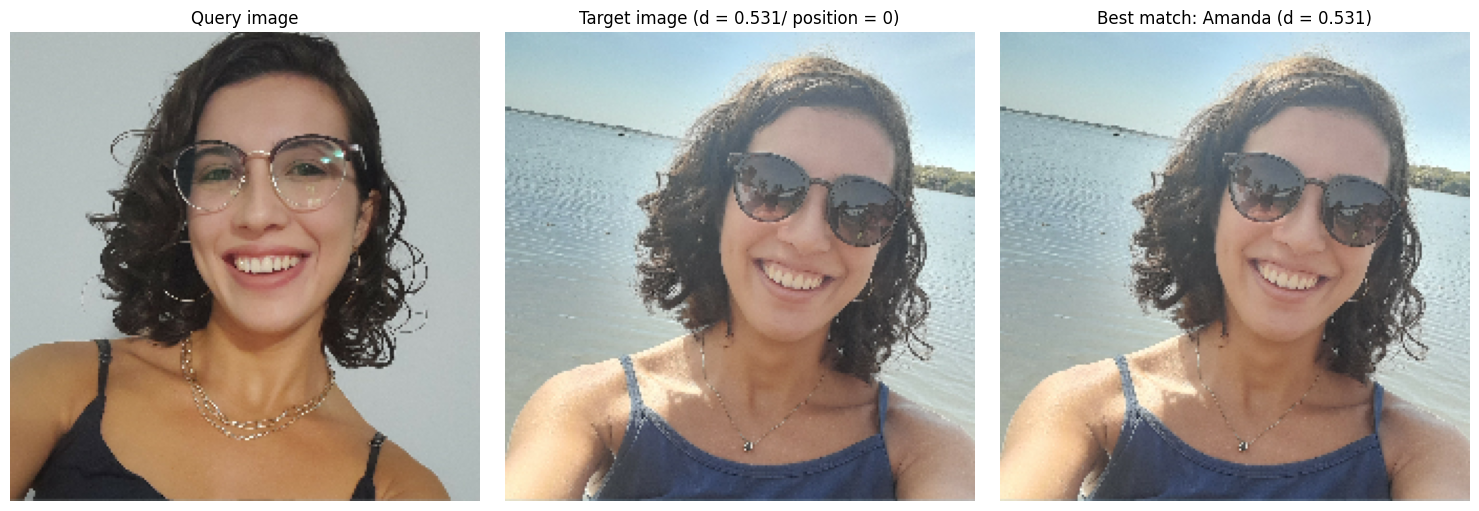

In [ ]:
query_img      = load_and_preprocess_image(f"./eu_festa2.jpg")
target_img     = load_and_preprocess_image(f"./eu_oculos.jpg")
best_match_img = load_and_preprocess_image(marcelinho_recog.iloc[0]["Filepath"])

images = [query_img, target_img, best_match_img]
titles = ["Query image",
          f"Target image (d = {target_row['Distance'].iloc[0]:.3f}/ position = {target_row.index.to_list()[0]})" ,
          f"Best match: {marcelinho_recog.iloc[0]['Label']} (d = {marcelinho_recog.iloc[0]['Distance']:.3f})"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(titles[i])

plt.tight_layout()
plt.show()

If model is good, move it to my drive (manual)

In [ ]:
!mv ./siamese_net_16 ./drive/MyDrive/siamese_cw_16